# Histopathologic Cancer Detection

## Inroduction

This notebook contains an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. Throughout the notebook you will find descriptions of the data, EDA procedure, a model that was built and trained, final results, and a conclusion.

The GitHub repository for this project can be found here: https://github.com/nabilahforuni/cancerdetection

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import Dataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-05-27 07:37:18.900326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 07:37:18.900426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 07:37:19.026944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Part I. Explorative Data Analysis

Let's load and familiarize ourselves with the data.

In [2]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'

In [3]:
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
train_size = len(os.listdir(train_dir))
test_size = len(os.listdir(test_dir))
train_size, test_size

(220025, 57458)

We see the about 60/40 distribution in the data, which is not ideal, but not bad either.

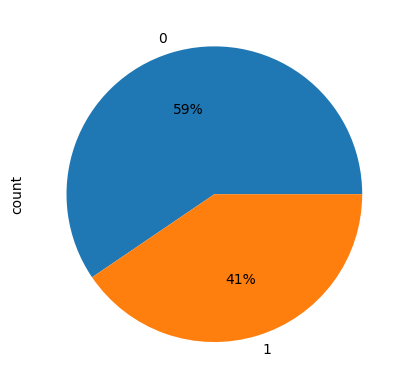

In [5]:
train_df.label.value_counts().plot.pie(autopct='%1.0f%%');

Let's load some images.

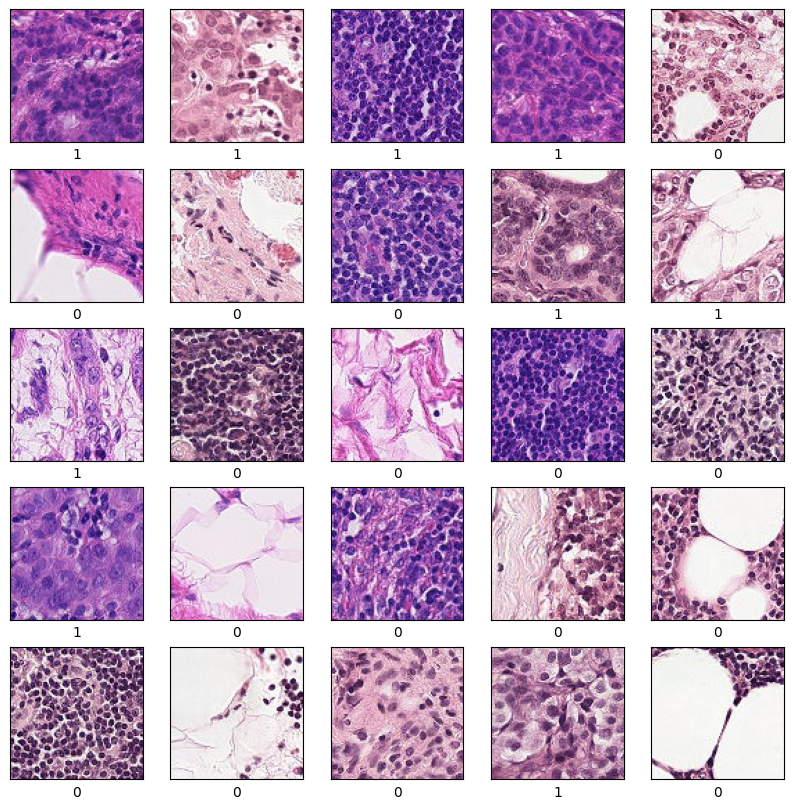

In [6]:
plt.figure(figsize=(10, 10))
for i, (id, label) in train_df.sample(n=25).reset_index(drop=True).iterrows():
    with open(f'{train_dir}/{id}.tif', 'rb') as img_file:
        image = plt.imread(img_file)
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [7]:
with open(f'{train_dir}/{train_df.id[0]}.tif', 'rb') as image_file:
    image = plt.imread(image_file)
    img_height, img_width, img_depth = image.shape

print(f'{img_height=}')
print(f'{img_width=}')
print(f'{img_depth=}')

img_height=96
img_width=96
img_depth=3


## Part II. Data Preprocessing

We'll create training and validation datasets, load the images and preprocess them for efficiency.

In [8]:
id2label = train_df.set_index('id')
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

In [9]:
list_ds = Dataset.list_files(train_dir +'/*.tif', shuffle=False)
list_ds = list_ds.shuffle(train_size, reshuffle_each_iteration=False)

In [10]:
val_size = int(train_size * 0.2)
train_ds = list_ds.skip(int(train_size * 0.8))
val_ds = list_ds.take(int(train_size * 0.05))
print(*(x.cardinality().numpy() for x in (train_ds, val_ds)))

44005 11001


In [11]:
list_ds_test = Dataset.list_files(test_dir +'/*.tif', shuffle=False)
print(list_ds_test.cardinality().numpy())

57458


In [12]:
def get_label(file_path):
    @ tf.py_function(Tout=tf.float32)
    def _label(idd):
        return id2label.loc[idd.numpy().decode('utf-8'), 'label']
    parts = tf.strings.split(file_path, os.path.sep)
    idd = tf.strings.split(parts[-1], '.')[0]
    label = _label(idd)
    label.set_shape(idd.get_shape())
    return label

In [13]:
def decode_img(img):
    img = tfio.experimental.image.decode_tiff(img)
    return tf.image.resize(img, [img_height, img_width])

In [14]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
def process_path_test(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [16]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = list_ds_test.map(process_path_test, num_parallel_calls=AUTOTUNE)

In [17]:
for image, label in train_ds.take(1):
    print(image.numpy().shape)
    print(label.numpy())

(96, 96, 4)
0.0


In [18]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

## Part III. CNN creation and training.

Let's create a funcion to plot training history first.

In [19]:
def plot_history(history):
    auc = history.history['AUC']
    val_auc = history.history['val_AUC']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, auc, label='Training AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.legend(loc='lower right')
    plt.title('Training and Validation AUC')
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')
    plt.show()

### First model

First, let's try a simple architecture with 3 convolutional layers (each with a ReLU activation function, 3x3 filter size and same padding), 3 max pooling layers after each of them, 1 fully-connected layer and finally an output layer with one neuron with sigmoid activation function.

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((96,96,4)),
    tf.keras.layers.Rescaling(1./255,),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,633 (4.59 MB)

 Trainable params: 1,203,633 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'AUC'])

In [ ]:
epochs = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=epochs
)

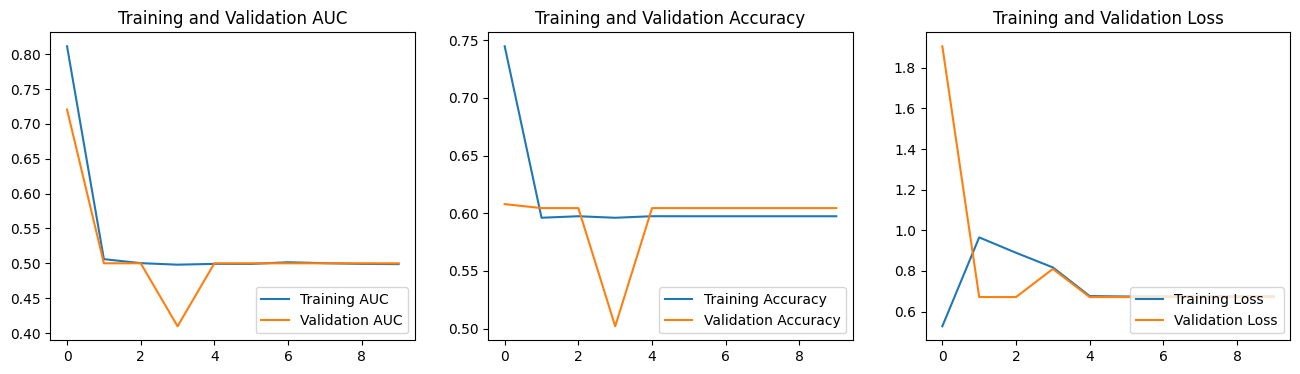

In [23]:
plot_history(history)

This model doesn't perform well, let's save it just in case and try another architecture.

In [24]:
model.save('/kaggle/working/model1.keras')

### Second model

Next, we will try a similar design but with 32 filters in each convolutional layers.

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((96,96,4)),
    tf.keras.layers.Rescaling(1./255,),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,537 (1.64 MB)

 Trainable params: 429,537 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'AUC'])

In [ ]:
epochs = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=epochs
)

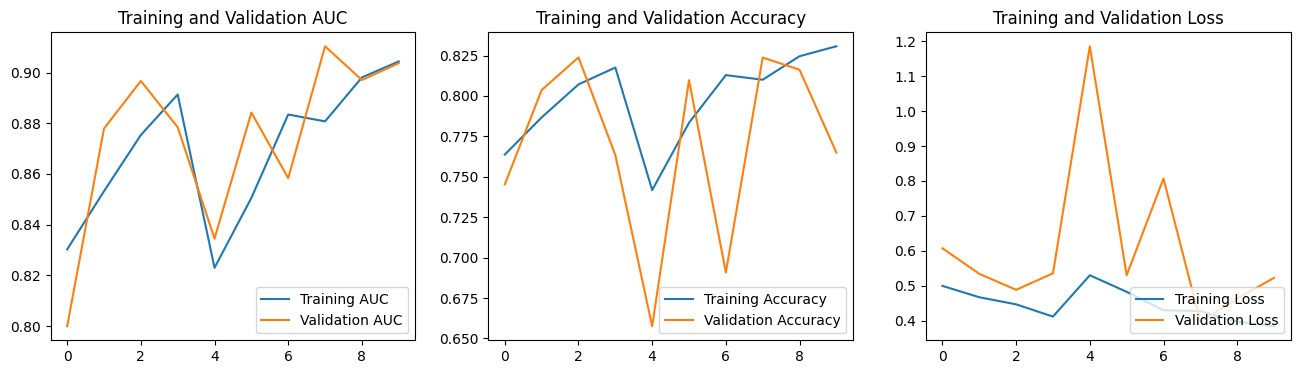

In [29]:
plot_history(history)

This model performs much better, but has some signs of overfitting.

In [30]:
model.save('/kaggle/working/model2.keras')

### Third model

We'll try to mitigate the overfitting in the previous model by adding a dropout layer after convolutional layers.

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((96,96,4)),
    tf.keras.layers.Rescaling(1./255,),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 96, 96, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,537 (1.64 MB)

 Trainable params: 429,537 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', 'AUC'])

In [34]:
epochs = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - AUC: 0.8070 - accuracy: 0.7493 - loss: 0.5165 - val_AUC: 0.8895 - val_accuracy: 0.8119 - val_loss: 0.4308
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.8764 - accuracy: 0.8103 - loss: 0.4330 - val_AUC: 0.8344 - val_accuracy: 0.5042 - val_loss: 1.8900
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - AUC: 0.7423 - accuracy: 0.6776 - loss: 0.6010 - val_AUC: 0.8519 - val_accuracy: 0.7706 - val_loss: 0.5915
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.8665 - accuracy: 0.7984 - loss: 0.4528 - val_AUC: 0.9037 - val_accuracy: 0.8288 - val_loss: 0.3922
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.8959 - accuracy: 0.8247 - loss: 0.4001 - val_AUC: 0.8875 - val_accuracy: 0.7122 - val_loss: 0.9154
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - AUC: 0.8030 - accuracy: 0.7441 - loss: 0.5480 - val_AUC: 0.8807 - val_accuracy: 0.7712 - val_loss: 0.4697
Epoch 7/10
1376/1376 ━━━━━━

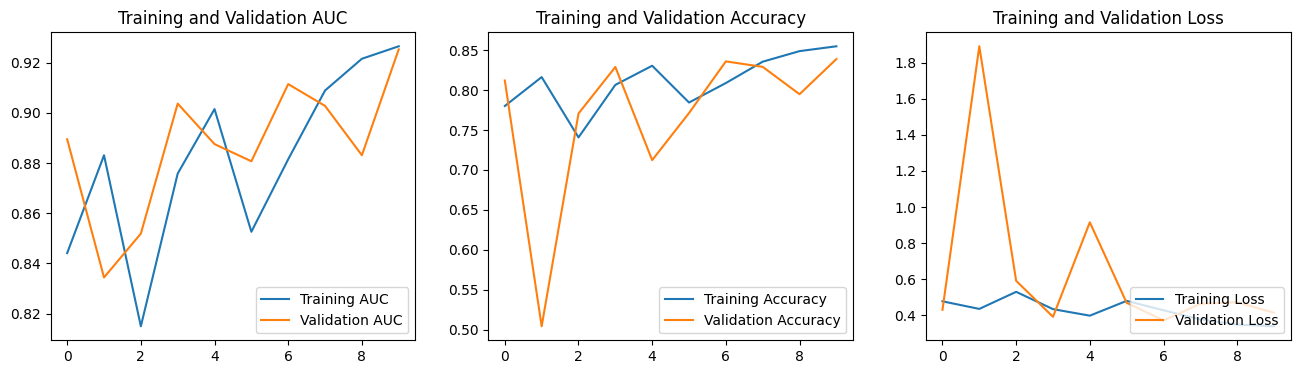

In [35]:
plot_history(history)

This model has less sign of overfitting and performs better overall. That's going to be the one which we will use for predictions and final submission.

In [36]:
model.save('/kaggle/working/model3.keras')

## Part IV

Predictions and submission.

In [38]:
model = tf.keras.models.load_model('/kaggle/working/model3.keras')
submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [ ]:
raw_predictions = model.predict(test_ds)
predictions = np.round(raw_predictions.flatten()).astype('int')
submission.label = predictions
submission.head()

In [40]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

This submission recieved private and public scores of 0.7776 and 0.8253 respectively, which is not that bad.

## Conclusion

We have trained three convolutional neural networks of different designs and found one that produces reasonable results.

## References

[1] https://www.tensorflow.org/tutorials/load_data/images

[2] https://www.tensorflow.org/tutorials/images/cnn

[3] https://www.tensorflow.org/tutorials/images/classification